In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
from sklearn.preprocessing import MultiLabelBinarizer

class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, model, label_encoder=None, max_length=512):
        """
        Args:
            texts: pandas Series or list of texts
            labels: list of label lists
            model: SBERT model
            label_encoder: MultiLabelBinarizer instance (optional)
            max_length: maximum sequence length
        """
        # Convert texts to list if it's a pandas Series
        self.texts = texts.tolist() if isinstance(texts, pd.Series) else texts
        
        # Initialize or use provided label encoder
        if label_encoder is None:
            self.label_encoder = MultiLabelBinarizer()
            self.labels = self.label_encoder.fit_transform(labels)
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(labels)
        
        self.model = model
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]  # Now a binary numpy array
        
        encoding = self.model._first_module().tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.float)
        }

class FineTunedSBERT(SentenceTransformer):
    def __init__(self, model_name='all-mpnet-base-v2', num_labels=20):
        super().__init__(model_name)
        for param in self.parameters():
            param.requires_grad = False
        
        for layer in self._first_module().auto_model.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        for param in self._first_module().auto_model.pooler.parameters():
            param.requires_grad = True
            
        hidden_size = self._first_module().auto_model.config.hidden_size
        self.classifier = torch.nn.Linear(hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self._first_module().auto_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100):
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame")
    
    df = df.dropna()
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])

    label_distribution = Counter([label for labels in labels for label in labels])
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    texts = texts[length_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[length_mask].reset_index(drop=True)
    
    return texts, filtered_labels

def get_embeddings(texts, model, batch_size=32):
    model.eval()
    embeddings = []
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch_texts = texts[i:i + batch_size].tolist()
            
            encoding = model._first_module().tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            outputs = model._first_module().auto_model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            
            embeddings.append(pooled_output.cpu().numpy())
    
    return np.vstack(embeddings)

def find_similar_requests(test_embeddings, train_embeddings, train_labels, top_k=5):
    """
    Find similar requests using cosine similarity.
    
    Args:
        test_embeddings: numpy array of shape (n_test, embedding_dim)
        train_embeddings: numpy array of shape (n_train, embedding_dim)
        train_labels: list of label lists
        top_k: number of similar items to retrieve
    """
    similarities = cosine_similarity(test_embeddings, train_embeddings)
    similar_indices = []
    similarity_scores = []
    
    for i in range(len(test_embeddings)):
        # Get indices of top-k similar items
        top_indices = np.argsort(similarities[i])[-top_k:][::-1]
        similar_indices.append(top_indices)
        similarity_scores.append(similarities[i][top_indices])
    
    return similar_indices, similarity_scores

def train_sbert_epoch(model, train_loader, criterion, optimizer, device, gradient_accumulation_steps=4):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    for i, batch in enumerate(tqdm(train_loader, desc="Training")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (i + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * gradient_accumulation_steps
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    if (i + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    return total_loss / len(train_loader)

def validate_sbert(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    return total_loss / len(val_loader)

def calculate_label_based_metrics(test_labels, train_labels, similar_indices, k_values=[1, 3, 5]):
    """
    Calculate precision@k, recall@k, F1@k and other metrics based on label matching.
    
    Args:
        test_labels: list of label lists
        train_labels: list of label lists
        similar_indices: list of arrays containing indices of similar items
        k_values: list of k values for precision@k, recall@k, and F1@k
    """
    metrics = {f'precision@{k}': [] for k in k_values}
    metrics.update({f'recall@{k}': [] for k in k_values})
    metrics.update({f'f1@{k}': [] for k in k_values})
    metrics.update({
        'avg_label_overlap': [],
        'total_matches': 0,
        'total_test_samples': len(test_labels)
    })
    
    for i, test_label_set in enumerate(test_labels):
        test_labels_set = set(test_label_set)
        retrieved_indices = similar_indices[i]
        
        matches_at_k = [0] * len(k_values)
        recall_at_k = [set() for _ in k_values]
        label_overlaps = []
        
        for j, idx in enumerate(retrieved_indices):
            train_labels_set = set(train_labels[idx])
            matching_labels = test_labels_set & train_labels_set  # Intersection
            
            if matching_labels:  # If there are matching labels
                for k_idx, k in enumerate(k_values):
                    if j < k:
                        matches_at_k[k_idx] += 1
                        recall_at_k[k_idx].update(matching_labels)
                
                overlap = len(matching_labels) / len(test_labels_set | train_labels_set)
                label_overlaps.append(overlap)
        
        for k_idx, k in enumerate(k_values):
            # Precision@k - proportion of retrieved items that are relevant
            precision_at_k = matches_at_k[k_idx] / k if k > 0 else 0
            metrics[f'precision@{k}'].append(precision_at_k)
            
            # Recall@k - proportion of relevant items that are retrieved
            recall = len(recall_at_k[k_idx]) / len(test_labels_set) if test_labels_set else 0
            metrics[f'recall@{k}'].append(recall)
            
            # F1@k - harmonic mean of precision and recall
            if precision_at_k + recall > 0:
                f1 = 2 * precision_at_k * recall / (precision_at_k + recall)
            else:
                f1 = 0
            metrics[f'f1@{k}'].append(f1)
        
        avg_overlap = np.mean(label_overlaps) if label_overlaps else 0
        metrics['avg_label_overlap'].append(avg_overlap)
        
        if any(matches_at_k):
            metrics['total_matches'] += 1
    
    # Calculate average metrics
    for k in k_values:
        metrics[f'avg_precision@{k}'] = np.mean(metrics[f'precision@{k}'])
        metrics[f'avg_recall@{k}'] = np.mean(metrics[f'recall@{k}'])
        metrics[f'avg_f1@{k}'] = np.mean(metrics[f'f1@{k}'])
    
    metrics['avg_label_overlap'] = np.mean(metrics['avg_label_overlap'])
    metrics['match_rate'] = metrics['total_matches'] / metrics['total_test_samples']
    
    return metrics

def plot_precision_at_k(metrics, k_values, run_dir):
    """
    Plot precision@k, recall@k, and F1@k values.
    """
    plt.figure(figsize=(12, 8))
    
    avg_precisions = [metrics[f'avg_precision@{k}'] for k in k_values]
    avg_recalls = [metrics[f'avg_recall@{k}'] for k in k_values]
    avg_f1s = [metrics[f'avg_f1@{k}'] for k in k_values]
    
    plt.plot(k_values, avg_precisions, marker='o', label='Precision@k')
    plt.plot(k_values, avg_recalls, marker='s', label='Recall@k')
    plt.plot(k_values, avg_f1s, marker='^', label='F1@k')
    
    plt.title('Evaluation Metrics at Different k Values')
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Still save the figure for later reference
    plt.savefig(os.path.join(run_dir, 'metrics_at_k.png'))
    plt.close()

def create_stratification_labels(labels_list, min_samples_per_label=2):
    """
    Create stratification labels that ensure each label has enough samples.
    Only considers labels that appear frequently enough for stratification.
    """
    # Count label occurrences
    label_counts = Counter([label for labels in labels_list for label in labels])
    
    # Keep only labels that appear frequently enough
    frequent_labels = {label for label, count in label_counts.items() if count >= min_samples_per_label}
    
    # Create binary indicators only for frequent labels
    stratification_indicators = []
    for labels in labels_list:
        # Create indicator only for frequent labels
        indicator = tuple(sorted(label for label in labels if label in frequent_labels))
        # If no frequent labels, use a special category
        if not indicator:
            indicator = ('rare_combination',)
        stratification_indicators.append(indicator)
    
    return stratification_indicators

def main(args):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len
    )
    
    # Initialize label encoder with all labels first
    print("\nInitializing label encoder...")
    mlb = MultiLabelBinarizer()
    mlb.fit(filtered_labels)
    print(f"Number of unique labels: {len(mlb.classes_)}")
    print("Labels:", mlb.classes_)
    
    # Initialize SBERT model with correct number of labels
    print("\nInitializing SBERT model...")
    model = FineTunedSBERT('all-mpnet-base-v2', num_labels=len(mlb.classes_))
    model.max_seq_length = 512
    model.use_fast_tokenizer = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create stratification indicators
    print("\nPreparing stratified split...")
    stratification_indicators = create_stratification_labels(filtered_labels)
    
    try:
        # Try stratified split and convert to lists
        train_indices, test_indices = train_test_split(
            range(len(texts)),
            test_size=0.1,
            random_state=42,
            stratify=stratification_indicators
        )
        
        # Use indices to split both texts and labels
        train_texts = texts.iloc[train_indices].reset_index(drop=True)
        test_texts = texts.iloc[test_indices].reset_index(drop=True)
        train_labels = [filtered_labels[i] for i in train_indices]
        test_labels = [filtered_labels[i] for i in test_indices]
        
        print("Successfully performed stratified split")
    except ValueError as e:
        print(f"Warning: Could not perform stratified split ({str(e)})")
        print("Falling back to random split")
        
        # Random split with indices
        train_indices, test_indices = train_test_split(
            range(len(texts)),
            test_size=0.1,
            random_state=42
        )
        
        # Use indices to split both texts and labels
        train_texts = texts.iloc[train_indices].reset_index(drop=True)
        test_texts = texts.iloc[test_indices].reset_index(drop=True)
        train_labels = [filtered_labels[i] for i in train_indices]
        test_labels = [filtered_labels[i] for i in test_indices]

    # Print split statistics
    train_label_dist = Counter([label for labels in train_labels for label in labels])
    test_label_dist = Counter([label for labels in test_labels for label in labels])
    
    print("\nLabel distribution in splits:")
    all_labels = sorted(set(train_label_dist.keys()) | set(test_label_dist.keys()))
    print("\nLabel          Train  Test")
    print("-" * 30)
    for label in all_labels:
        train_count = train_label_dist.get(label, 0)
        test_count = test_label_dist.get(label, 0)
        print(f"{label[:10]:12} {train_count:5d} {test_count:5d}")

    print(f"\nTotal samples - Training: {len(train_texts)}, Testing: {len(test_texts)}")
    
    # Create datasets with shared label encoder
    train_dataset = MultiLabelDataset(train_texts, train_labels, model, label_encoder=mlb)
    test_dataset = MultiLabelDataset(test_texts, test_labels, model, label_encoder=mlb)
    
    # Create data loaders
    effective_batch_size = args.batch_size // 4
    gradient_accumulation_steps = 4
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=effective_batch_size,
        shuffle=True,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=effective_batch_size,
        num_workers=0
    )
    
    # Fine-tune SBERT if specified
    if args.training_epochs > 0:
        criterion = BCEWithLogitsLoss()
        optimizer = AdamW(model.parameters(), lr=2e-5)
        
        best_loss = float('inf')
        train_losses = []
        test_losses = []
        
        print(f"\nStarting SBERT fine-tuning for {args.training_epochs} epochs...")
        
        for epoch in range(args.training_epochs):
            print(f"\nEpoch {epoch+1}/{args.training_epochs}")
            
            train_loss = train_sbert_epoch(
                model, train_loader, criterion, optimizer, device, gradient_accumulation_steps
            )
            
            test_loss = validate_sbert(
                model, test_loader, criterion, device
            )
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Test Loss: {test_loss:.4f}")
            
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model.state_dict(), os.path.join(run_dir, 'best_sbert_model.pt'))
                print("Saved new best model")
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Plot training curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title('Training and Test Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(run_dir, 'training_curves.png'))
        plt.close()
        
        # Load best model for generating embeddings
        model.load_state_dict(torch.load(os.path.join(run_dir, 'best_sbert_model.pt')))
    
    model.eval()
    
    # Generate embeddings for training and testing sets
    print("\nGenerating embeddings with model...")
    train_embeddings = get_embeddings(train_texts, model, batch_size=args.batch_size)
    test_embeddings = get_embeddings(test_texts, model, batch_size=args.batch_size)
    
    # Find similar requests for each test sample
    print("\nFinding similar requests...")
    similar_indices, similarity_scores = find_similar_requests(
        test_embeddings, train_embeddings, train_labels, top_k=args.top_k
    )
    
    # Calculate label-based metrics
    print("\nCalculating label-based metrics...")
    k_values = [1, 3, 5]  # Calculate precision@1, @3, and @5
    label_metrics = calculate_label_based_metrics(test_labels, train_labels, similar_indices, k_values)
    
    # Print metrics
    print("\nLabel-based Metrics:")
    print(f"Match Rate (at least one match): {label_metrics['match_rate']:.4f}")
    for k in k_values:
        print(f"Average Precision@{k}: {label_metrics[f'avg_precision@{k}']:.4f}")
        print(f"Average Recall@{k}: {label_metrics[f'avg_recall@{k}']:.4f}")
        print(f"Average F1@{k}: {label_metrics[f'avg_f1@{k}']:.4f}")
    print(f"Average Label Overlap: {label_metrics['avg_label_overlap']:.4f}")
    
    # Plot metrics@k
    plot_precision_at_k(label_metrics, k_values, run_dir)
    
    # Save results
    results = {
        'text_column': args.text_column,
        'similar_requests': {
            'indices': [indices.tolist() for indices in similar_indices],
            'scores': [scores.tolist() for scores in similarity_scores]
        },
        'label_metrics': label_metrics,
        'sbert_training': {
            'train_losses': train_losses if args.training_epochs > 0 else [],
            'test_losses': test_losses if args.training_epochs > 0 else [],
            'best_loss': float(best_loss) if args.training_epochs > 0 else None
        }
    }
    
    # Save detailed similarity results with label matching information
    similarity_results = []
    for i, (indices, scores) in enumerate(zip(similar_indices, similarity_scores)):
        test_sample = {
            'test_text': test_texts.iloc[i],
            'test_labels': test_labels[i],
            'similar_requests': []
        }
        
        test_labels_set = set(test_labels[i])
        for j, (idx, score) in enumerate(zip(indices, scores)):
            train_labels_set = set(train_labels[idx])
            matching_labels = list(test_labels_set & train_labels_set)
            
            similar_request = {
                'rank': j + 1,
                'text': train_texts.iloc[idx],
                'labels': train_labels[idx],
                'similarity_score': float(score),
                'matching_labels': matching_labels,
                'has_matching_label': len(matching_labels) > 0
            }
            test_sample['similar_requests'].append(similar_request)
        
        similarity_results.append(test_sample)
    
    with open(os.path.join(run_dir, 'similarity_results.json'), 'w') as f:
        json.dump(similarity_results, f, indent=4)
    
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    print(f"\nAnalysis completed! Results saved to {run_dir}")
    
    return {
        'model': model,
        'train_embeddings': train_embeddings,
        'test_embeddings': test_embeddings,
        'similar_indices': similar_indices,
        'similarity_scores': similarity_scores,
        'label_metrics': label_metrics,
        'results_dir': run_dir
    }

2025-04-14 07:50:03.109597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744617003.288072      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744617003.343818      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...

Initializing label encoder...
Number of unique labels: 20
Labels: ['area/apiserver' 'area/cloudprovider' 'area/code-generation'
 'area/conformance' 'area/custom-resources' 'area/dependency'
 'area/e2e-test-framework' 'area/etcd' 'area/ipvs' 'area/kube-proxy'
 'area/kubeadm' 'area/kubectl' 'area/kubelet' 'area/provider/azure'
 'area/provider/gcp' 'area/provider/openstack' 'area/provider/vmware'
 'area/release-eng' 'area/security' 'area/test']

Initializing SBERT model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Preparing stratified split...
Falling back to random split

Label distribution in splits:

Label          Train  Test
------------------------------
area/apise     191    32
area/cloud     169    25
area/code-      45     9
area/confo      16     0
area/custo      13     3
area/depen      66    11
area/e2e-t      19     4
area/etcd        3     2
area/ipvs       43     4
area/kube-      28     2
area/kubea      45     2
area/kubec     131    14
area/kubel     330    42
area/provi      62     5
area/provi      26     3
area/provi       5     0
area/provi       4     2
area/relea      18     0
area/secur      11     0
area/test      294    32

Total samples - Training: 1099, Testing: 123

Starting SBERT fine-tuning for 20 epochs...

Epoch 1/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]


Train Loss: 0.6182
Test Loss: 0.5406
Saved new best model

Epoch 2/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Train Loss: 0.4908
Test Loss: 0.4323
Saved new best model

Epoch 3/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Train Loss: 0.3888
Test Loss: 0.3434
Saved new best model

Epoch 4/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Train Loss: 0.3099
Test Loss: 0.2852
Saved new best model

Epoch 5/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Train Loss: 0.2614
Test Loss: 0.2544
Saved new best model

Epoch 6/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Train Loss: 0.2355
Test Loss: 0.2388
Saved new best model

Epoch 7/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Train Loss: 0.2226
Test Loss: 0.2304
Saved new best model

Epoch 8/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Train Loss: 0.2151
Test Loss: 0.2254
Saved new best model

Epoch 9/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Train Loss: 0.2107
Test Loss: 0.2204
Saved new best model

Epoch 10/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Train Loss: 0.2050
Test Loss: 0.2117
Saved new best model

Epoch 11/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Train Loss: 0.1989
Test Loss: 0.2047
Saved new best model

Epoch 12/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Train Loss: 0.1935
Test Loss: 0.1994
Saved new best model

Epoch 13/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Train Loss: 0.1879
Test Loss: 0.1945
Saved new best model

Epoch 14/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Train Loss: 0.1830
Test Loss: 0.1884
Saved new best model

Epoch 15/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Train Loss: 0.1771
Test Loss: 0.1827
Saved new best model

Epoch 16/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Train Loss: 0.1705
Test Loss: 0.1802
Saved new best model

Epoch 17/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Train Loss: 0.1652
Test Loss: 0.1735
Saved new best model

Epoch 18/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Train Loss: 0.1586
Test Loss: 0.1647
Saved new best model

Epoch 19/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Train Loss: 0.1520
Test Loss: 0.1591
Saved new best model

Epoch 20/20


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Train Loss: 0.1460
Test Loss: 0.1528
Saved new best model


/tmp/ipykernel_19/3782835070.py:498: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(run_dir, 'best_sbert_model.pt')))



Generating embeddings with model...


Generating embeddings: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]



Finding similar requests...

Calculating label-based metrics...

Label-based Metrics:
Match Rate (at least one match): 0.9431
Average Precision@1: 0.8618
Average Recall@1: 0.7733
Average F1@1: 0.7985
Average Precision@3: 0.8455
Average Recall@3: 0.8661
Average F1@3: 0.8292
Average Precision@5: 0.8390
Average Recall@5: 0.8770
Average F1@5: 0.8280
Average Label Overlap: 0.7533


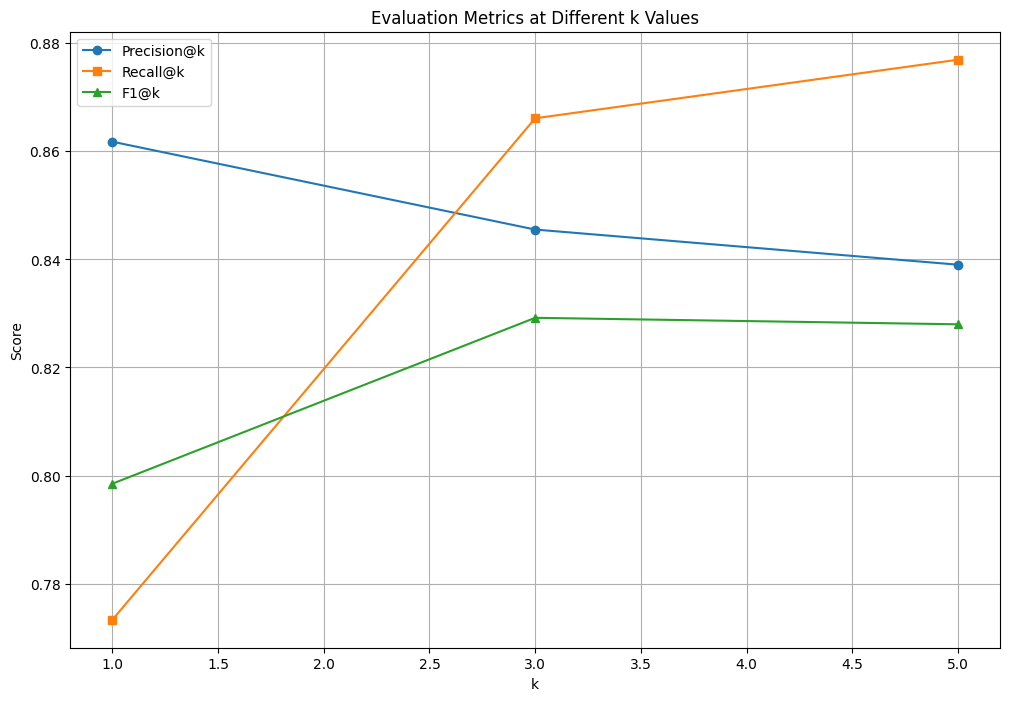


Analysis completed! Results saved to ./results/run_20250414_075016_all_text_0.5


In [2]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Compare change requests using SBERT embeddings and cosine similarity')
    
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Batch size for generating embeddings')
    parser.add_argument('--training_epochs', type=int, default=20,
                        help='Number of epochs for SBERT fine-tuning (0 to skip)')
    parser.add_argument('--top_k', type=int, default=5,
                        help='Number of similar requests to find for each test sample')
    
    args, unknown = parser.parse_known_args()
    results = main(args) 

Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...

Initializing label encoder...
Number of unique labels: 20
Labels: ['area/apiserver' 'area/cloudprovider' 'area/code-generation'
 'area/conformance' 'area/custom-resources' 'area/dependency'
 'area/e2e-test-framework' 'area/etcd' 'area/ipvs' 'area/kube-proxy'
 'area/kubeadm' 'area/kubectl' 'area/kubelet' 'area/provider/azure'
 'area/provider/gcp' 'area/provider/openstack' 'area/provider/vmware'
 'area/release-eng' 'area/security' 'area/test']

Initializing SBERT model...

Preparing stratified split...
Falling back to random split

Label distribution in splits:

Label          Train  Test
------------------------------
area/apise     191    32
area/cloud     169    25
area/code-      45     9
area/confo      16     0
area/custo      13     3
area/depen      66    11
area/e2e-t      19     4
area/etcd        3     2
area/ipvs       43     4
area/kube-      28    

Generating embeddings: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]



Finding similar requests...

Calculating label-based metrics...

Label-based Metrics:
Match Rate (at least one match): 0.9268
Average Precision@1: 0.7073
Average Recall@1: 0.6192
Average F1@1: 0.6444
Average Precision@3: 0.6938
Average Recall@3: 0.8354
Average F1@3: 0.7255
Average Precision@5: 0.6553
Average Recall@5: 0.8824
Average F1@5: 0.7173
Average Label Overlap: 0.6739


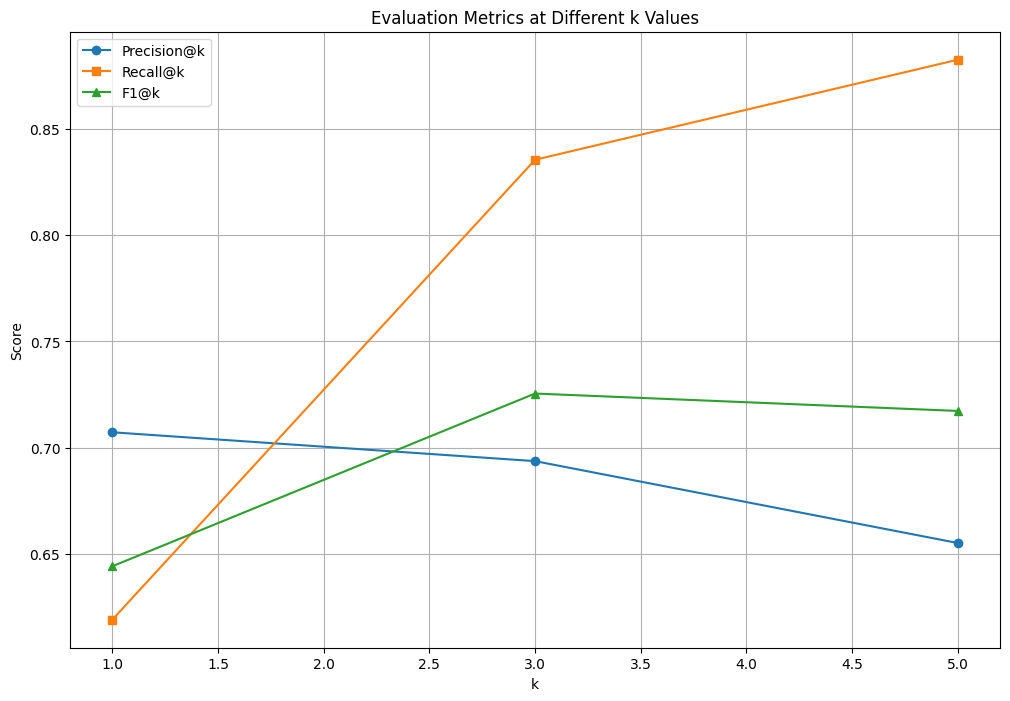


Analysis completed! Results saved to ./results/run_20250414_081454_all_text_0.5


In [3]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Compare change requests using SBERT embeddings and cosine similarity')
    
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Batch size for generating embeddings')
    parser.add_argument('--training_epochs', type=int, default=0,
                        help='Number of epochs for SBERT fine-tuning (0 to skip)')
    parser.add_argument('--top_k', type=int, default=5,
                        help='Number of similar requests to find for each test sample')
    
    args, unknown = parser.parse_known_args()
    results = main(args) 